# Using Fractional Cover (FC) to train a Random Forest (RF) Classifier for Land-cover Classification

The goal in this notebook is to train a classifier at the regional scale (Pacific) to get land-cover classification. The Pacific Islands face a critical lack of locally accurate land cover datasets. Existing global products are designed for continental or global scales and often fail to capture the nuanced land cover dynamics of the Pacific region. This leads to misclassification, underrepresentation of smaller land cover types, and unreliable data for local decision-making. The goal of our Random Forest classifier trained on fractional cover data and spectral data is to addresse this gap by providing a regionally tuned, high resolution land cover product specifically trained on Pacific island environments (e.g., Fiji, Cook Islands, Marshall Islands). 

In [1]:
import pandas as pd
import numpy as np 
import xarray as xr
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, classification_report, confusion_matrix
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import rasterio
from matplotlib.patches import Patch
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
import seaborn as sns

In [163]:
# dataset path + loading

fiji_path = "./data/fiji.xlsx"
marshall_path = "./data/marshall.xlsx"
cook_path = "./data/cook.xlsx"
palaos_path = "./data/palaos.xlsx"

fj = pd.read_excel(fiji_path)
mh =  pd.read_excel(marshall_path)
ck =  pd.read_excel(cook_path)
pl =  pd.read_excel(palaos_path)

fj.head()

,fid,class_id,lulc,bs_pc_50,npv_pc_50,pv_pc_50,lon,lat,ndvi1,ndwi1,...,ndvi_mar1,ndvi_apr1,ndvi_may1,ndvi_jun1,ndvi_jul1,ndvi_aug1,ndvi_sep1,ndvi_oct1,ndvi_nov1,ndvi_dec1
0,1,1,forest,9,0,87,178.325,-17.535,0.884564,-0.775417,...,0.839043,0.867860,0.868324,0.890288,0.886043,0.843069,0.813990,0.807554,0.876050,0.878468
1,2,1,forest,5,8,94,178.300,-17.535,0.823159,-0.711232,...,0.859547,0.862402,0.840681,0.876270,0.822355,0.806601,0.755177,0.708879,0.721625,0.776744
2,3,2,cropland,7,20,76,177.511,-17.551,0.804638,-0.734354,...,0.849030,0.886709,0.882106,0.819583,0.821527,0.793322,0.719800,0.625262,0.677987,0.797901
3,4,1,forest,2,10,89,177.651,-17.550,0.838690,-0.754122,...,0.780062,0.829818,0.829482,0.852208,0.838675,0.792722,0.786260,0.611784,0.626410,0.613761
4,5,2,cropland,8,31,60,177.664,-17.550,0.583125,-0.570485,...,0.740318,0.754108,0.762808,0.761893,0.760045,0.360234,0.332080,0.396548,0.569180,0.703799


## 1. Data Preparation 

Data from Fiji, Cook Island, Marshall Island and Palaos were download to train a random forest that return land cover classification over the pacific region. We have for each island a shapefile containing point with the associated grountruth land cover label and position (lat, lon) and from the Sentinel-2 geomad, the RGB-NIR band were downloaded to compute the NDVI and NDWI and finally with .tif file with 3 bands for the annual fractionnal cover over each island. Then, we prepare the data using QGIS to have one dataset (shapefile) for each island containing for each point the following data :

- lat, lon
- Fractional Cover (bs : baresoil ; pv : photosynthetic vegetation ; npv : non-photosynthetic vegetation)
- NDVI
- NDWI
- NDBI (Normalized Difference Build Index)
- RGB-NIR (spectral bands)
- Label (class-id : 1. Forest ; 2. Cropland ; 3. Grassland ; 4. Buildup ; 5. Baresoil ; 6. Water ; 7. Mangroves)
- lulc (land-use, land-cover)
- Texture data (10 bands computed using Haralick Extraction Feature in QGIS --> GLCM)

The data are in the folder data, there 4 files (one per island).

In [4]:
# Create a table summarizing the lulc category distribution 

def count_lulc(df, island_name):
    counts = df["lulc"].value_counts().to_frame(name=island_name).T
    return counts

fj_counts = count_lulc(fj, "Fiji")
mh_counts = count_lulc(mh, "Marshall")
ck_counts = count_lulc(ck, "Cook")
pl_counts = count_lulc(pl, "Palaos")

summary = pd.concat([fj_counts, mh_counts, ck_counts, pl_counts], axis=0).fillna(0).astype(int)
summary["Total"] = summary.sum(axis=1)
summary = summary.sort_values(by="Total", ascending=False)

summary.head()

lulc,forest,grassland,mangroves,cropland,buildup,water,baresoil,Total
Fiji,3122,1451,592,536,130,38,15,5884
Cook,103,59,0,80,113,55,162,572
Palaos,72,77,18,63,42,36,177,485
Marshall,142,22,6,4,47,17,50,288


This summary table shows that there are a lot of data point in Fidji (on average 10 times more than in the other island) and that forest label is also over-represented. If we train a classifier directly on all the data, it will learn only charactheristics from this class and location and thus the classifier will be very bad on other class or other location. To avoid this, we need to balance the dataset before training the classifier.

### Deal with imbalance dataset

To build a good classifier that generalizes well across the Pacific, balancing data is important :

- Balancing between classes (so each LULC type is equally learned)
- Balancing between locations (so it doesn't overfit to any specific island)

But a minimum amount of data is needed in order to have a good classifier. Regarging the previous table, the less represented classes are water (155) and buildup (339). Based on this, the objective is to keep aroun 150-300 points per lulc. Finally to preserve spatial generalization, points from each island should be equally reprensented in each class.

I set manually : 

- Forest : Fiji : 80 ; Cook : 75 ; Palaos : 70 ; Marshall : 75 = 300
- Grassland : Fiji : 150 ; Cook : 59 ; Palaos : 77 ; Marshall : 22 = 308
- Mangroves : Fiji : 180 ; Cook : 0 ; Palaos : 18 ; Marshall : 6 = 204
- Cropland : Fiji : 150 ; Cook : 80 ; Palaos : 63 ; Marshall : 4 = 300
- Buildup : Fiji : 110 ; Cook : 110 ; Palaos : 40 ; Marshall : 40 = 300
- Water : Fiji : 39 ; Cook : 55 ; Palaos : 36 ; Marshall : 25 = 155
- Baresoil : Fiji : 15 ; Cook : 115 ; Palaos : 115 ; Marshall : 55 = 300

Following this distribution, the RF would be trained on 1867 data points.

In [97]:
random.seed(42)

"""
sampling_plan = {
    "forest":     {"Fiji": 80,  "Cook": 75,  "Palaos": 70,  "Marshall": 75},
    "grassland":  {"Fiji": 140, "Cook": 59,  "Palaos": 77,  "Marshall": 22},
    "mangroves":  {"Fiji": 180, "Cook": 0,   "Palaos": 18,  "Marshall": 6},
    "cropland":   {"Fiji": 155, "Cook": 80,  "Palaos": 63,  "Marshall": 4},
    "buildup":    {"Fiji": 110, "Cook": 110, "Palaos": 40,  "Marshall": 40},
    "water":      {"Fiji": 38,  "Cook": 55,  "Palaos": 36,  "Marshall": 17},
    "baresoil":   {"Fiji": 15,  "Cook": 115, "Palaos": 115, "Marshall": 15}
}
"""
sampling_plan = {
    "forest":     {"Fiji": 450,  "Cook": 75,  "Palaos": 70,  "Marshall": 75},
    "grassland":  {"Fiji": 500, "Cook": 59,  "Palaos": 77,  "Marshall": 22},
    "mangroves":  {"Fiji": 500, "Cook": 0,   "Palaos": 18,  "Marshall": 6},
    "cropland":   {"Fiji": 500, "Cook": 80,  "Palaos": 63,  "Marshall": 4},
    "buildup":    {"Fiji": 110, "Cook": 110, "Palaos": 40,  "Marshall": 40},
    "water":      {"Fiji": 38,  "Cook": 55,  "Palaos": 36,  "Marshall": 17},
    "baresoil":   {"Fiji": 15,  "Cook": 160, "Palaos": 177, "Marshall": 50}
}
island_dfs = {
    "Fiji": fj,
    "Cook": ck,
    "Palaos": pl,
    "Marshall": mh
}


samples = []


for lulc_class, island_counts in sampling_plan.items():
    for island, n_points in island_counts.items():
        if n_points == 0:
            continue
        df = island_dfs[island]
        df_filtered = df[df["lulc"] == lulc_class]

        if len(df_filtered) < n_points:
            raise ValueError(f"Not enough data for {lulc_class} in {island} (needed {n_points}, available {len(df_filtered)})")

        # Convert to list of rows (dicts), sample with random
        filtered_list = df_filtered.to_dict(orient="records")
        selected = random.sample(filtered_list, n_points)

        # Reconvert to DataFrame and add island info
        selected_df = pd.DataFrame(selected)
        selected_df["island"] = island
        samples.append(selected_df)

# Concatenate all sampled rows
train_df = pd.concat(samples, ignore_index=True)

# Check result
print("Final shape:", train_df.shape)
print("Class counts:\n", train_df["lulc"].value_counts())
print("Island counts:\n", train_df["island"].value_counts())


Final shape: (3347, 50)
Class counts:
 lulc
forest       670
grassland    658
cropland     647
mangroves    524
baresoil     402
buildup      300
water        146
Name: count, dtype: int64
Island counts:
 island
Fiji        2113
Cook         539
Palaos       481
Marshall     214
Name: count, dtype: int64


In [98]:
train_df = train_df.drop(columns=['fid'])
df = train_df.sample(frac=1).reset_index(drop=True)
df.head()

,class_id,lulc,bs_pc_50,npv_pc_50,pv_pc_50,lon,lat,ndvi1,ndwi1,red1,...,ndvi_may1,ndvi_jun1,ndvi_jul1,ndvi_aug1,ndvi_sep1,ndvi_oct1,ndvi_nov1,ndvi_dec1,island,ndvi_feb1
0,6,water,25,50,43,134.553,7.362,0.362859,-0.336940,1266.0,...,0.272538,0.248611,0.337809,0.393113,0.354137,0.338264,0.279855,0.279855,Palaos,0.451237
1,5,baresoil,20,12,82,134.586,7.351,0.330185,-0.462940,1560.0,...,0.378446,0.395896,0.339666,0.367533,0.414322,0.388486,0.471240,0.471240,Palaos,0.431367
2,4,buildup,17,57,24,134.471,7.341,0.299459,-0.214728,1296.0,...,0.126287,0.123378,0.094731,0.158061,0.125275,0.124820,0.130616,0.130616,Palaos,0.166907
3,1,forest,3,8,92,171.319,7.123,0.821762,-0.709333,439.0,...,0.781014,0.793443,0.818949,0.813507,0.820829,0.786887,0.810659,0.763011,Marshall,0.749918
4,3,grassland,3,16,89,177.513,-18.088,0.836773,-0.710183,344.0,...,0.842722,0.785320,0.794789,0.755274,0.717959,0.713767,0.756903,0.741533,Fiji,NaN


In [7]:
# save the training dataset
df.to_excel('./data/training_data.xlsx')

## 2. Training RF Classifier

Initial training was performed using only Fractional Cover (FC) features. While the model learned general patterns, it failed to capture class-specific characteristics, resulting in low accuracy (~55%). To improve performance, spectral features (RGB bands) and vegetation/water indices (NDVI, NDWI) were added. This enriched the feature space with reflectance-based and moisture-related information, increasing accuracy to ~65%. However, the model still struggled to distinguish cropland, grassland, and forest—likely due to their spectral similarity.

To better capture spatial context, NDVI texture features were introduced using GLCM (Haralick features computed in QGIS). A [study](https://www.tandfonline.com/doi/full/10.1080/01431161.2016.1278314) suggests GLCM mean is most effective for classification, with contrast and entropy adding value in edge-rich or detailed contexts. Since band 1 appears to represent the mean, it was retained as texture1. A PCA-based reduction of all texture bands was tested but performed poorly—likely due to loss of spatial nuance—so only texture1 was kept.

Vegetation indices such as EVI and SAVI were also tested to better discriminate dense versus sparse vegetation. However, their inclusion led to misclassification, especially overprediction of cropland, suggesting feature redundancy or class confusion. NDBI, intended to improve separation of bare soil, lead to more forest pixel classify as baresoil or cropland but increase overall performance.

Alternative classifiers (XGBoost, SVM) and ensemble stacking were tested but underperformed compared to Random Forest, possibly due to the small or imbalanced training dataset.

Finally, the NDVI class-wise mean per island (ndvi_mean) was added. While this greatly boosted accuracy (~96%), it dominated feature importance, causing overfitting by allowing the model to learn class identity rather than general patterns.

In [ ]:
# Select Features and Labels 
#features = df[['bs_pc_50', 'npv_pc_50', 'pv_pc_50', 'ndvi1', 'ndwi1', 'red1', 'green1', 'blue1', 'texture1', 'ndbi1']] #'nir1', 'savi', 'evi',  'ndbi1', ...
#features = df[['bs_pc_50','pv_pc_50', 'npv_pc_50', 'pv_jan_apr', 'pv_sep_dec', 'ndvi1', 'ndbi1', 'ndwi1', 'red1','green1', 'blue1', 'texture1', 'ndwi1', 'savi']]
features = df[['bs_pc_50','pv_pc_50', 'npv_pc_50', 'ndvi_jan1', 'ndvi_mar1', 'ndvi_apr1', 'ndvi_may1',	'ndvi_jun1','ndvi_jul1','ndvi_aug1','ndvi_sep1', 'ndvi_oct1', 'ndvi_nov1', 'ndvi_dec1',
               'ndwi1', 'ndbi1', 'red1', 'green1', 'blue1', 'texture1', 'pv_jan_apr', 'pv_sep_dec', 'bs_jan_apr', 'bs_may_aug', 'bs_sep_dec', 'npv_jan_ap', 'npv_may_au', 'npv_sep_de', 'evi']]
labels = df['class_id']

# Train/Test Split 
X_train, X_val, y_train, y_val = train_test_split(
    features, labels, test_size=0.2, random_state=42)

# Train Random Forest Classifier 
rf = RandomForestClassifier(
    n_estimators=800,
    random_state=42,
    class_weight='balanced', 
    max_features = 'sqrt', 
    bootstrap = True, 
    criterion = 'entropy')

rf.fit(X_train, y_train)

# Make Predictions 
y_pred = rf.predict(X_val)

# Performance  Metrics
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='weighted')
kappa = cohen_kappa_score(y_val, y_pred)
report = classification_report(y_val, y_pred)


# Results 
print("Random Forest Classifier Performance")
print(f"Accuracy: {accuracy:.2%}")
print(f"Weighted F1-score: {f1:.2%}")
print(f"Cohen's Kappa: {kappa:.3f}")
print("\nClassification Report:\n", report)


In [251]:
# Get Feature Importances
importances = rf.feature_importances_
feature_names = features.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print Table
print("\nFeature Importances:")
print(importance_df)


Feature Importances:
       Feature  Importance
15       ndbi1    0.114011
16        red1    0.069469
14       ndwi1    0.069392
5    ndvi_apr1    0.046340
17      green1    0.045183
19    texture1    0.044492
18       blue1    0.041480
1     pv_pc_50    0.040634
4    ndvi_mar1    0.036032
11   ndvi_oct1    0.033197
12   ndvi_nov1    0.032761
10   ndvi_sep1    0.031899
20  pv_jan_apr    0.031427
28         evi    0.030935
9    ndvi_aug1    0.026694
21  pv_sep_dec    0.026570
6    ndvi_may1    0.026298
13   ndvi_dec1    0.024996
8    ndvi_jul1    0.024500
27  npv_sep_de    0.024243
26  npv_may_au    0.022422
24  bs_sep_dec    0.021573
25  npv_jan_ap    0.021460
3    ndvi_jan1    0.021086
7    ndvi_jun1    0.020739
22  bs_jan_apr    0.019632
23  bs_may_aug    0.019514
0     bs_pc_50    0.017496
2    npv_pc_50    0.015527


Highly correlated feature pairs (>|0.95|):
      Feature1   Feature2  Correlation
98   ndvi_mar1  ndvi_apr1     0.972737
99   ndvi_mar1  ndvi_may1     0.958654
120  ndvi_apr1  ndvi_may1     0.966988
121  ndvi_apr1  ndvi_jun1     0.953198
141  ndvi_may1  ndvi_jun1     0.953013
161  ndvi_jun1  ndvi_jul1     0.962673
180  ndvi_jul1  ndvi_aug1     0.964182
198  ndvi_aug1  ndvi_sep1     0.968014
199  ndvi_aug1  ndvi_oct1     0.960073
215  ndvi_sep1  ndvi_oct1     0.965888
231  ndvi_oct1  ndvi_nov1     0.957121
285       red1     green1     0.972148
286       red1      blue1     0.967398
296     green1      blue1     0.978612


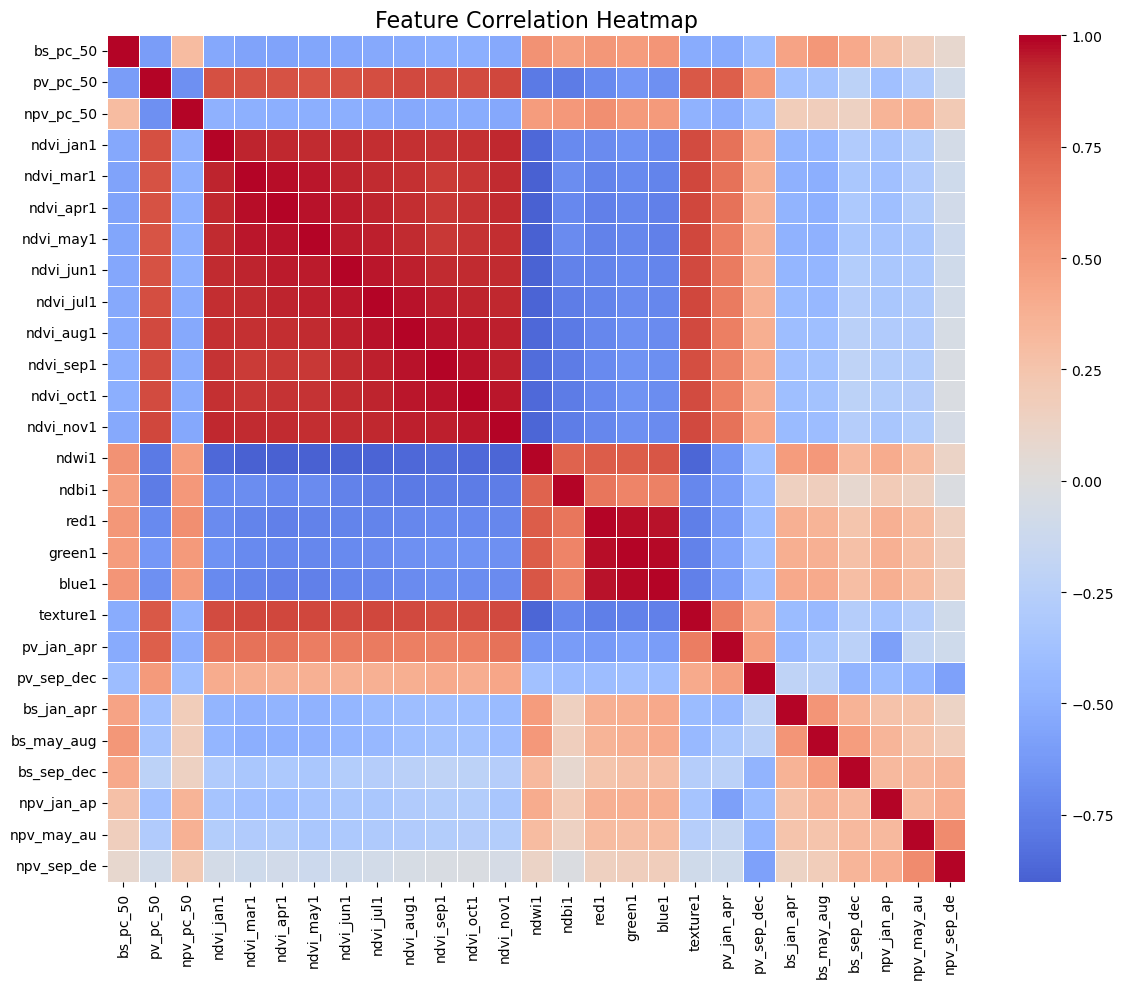

In [173]:
df_features = features
corr_matrix = df_features.corr()

threshold = 0.95
corr_pairs = (
    corr_matrix
    .where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))  # keep upper triangle
    .stack()  # convert to long format
    .reset_index()
)
corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_corr = corr_pairs[abs(corr_pairs['Correlation']) > threshold]

print("Highly correlated feature pairs (>|0.95|):")
print(high_corr)

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=False,        # set True if you want the correlation numbers
    cmap='coolwarm',
    center=0,
    linewidths=0.5
)
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

## 3. Testing and Show Results

In [192]:
test_path = './data/fiji_test.xlsx'
fiji_test = pd.read_excel(test_path)
fiji_test.head()

,fid,class_id,lulc,lon,lat,bs_pc_50,npv_pc_50,pv_pc_50,ndvi1,ndwi1,...,ndvi_mar1,ndvi_apr1,ndvi_may1,ndvi_jun1,ndvi_jul1,ndvi_aug1,ndvi_sep1,ndvi_oct1,ndvi_nov1,ndvi_dec1
0,4884,2,cropland,179.880846,-16.189437,5,25,67,0.687194,-0.666582,...,0.639808,0.711985,0.721354,0.733172,0.697332,0.612364,0.538295,0.608772,0.570598,0.581472
1,4889,3,grassland,179.691789,-16.204109,3,10,92,0.786174,-0.655252,...,0.764901,0.831982,0.825232,0.844361,0.844055,0.715994,0.753183,0.734268,0.760370,0.697904
2,4890,3,grassland,179.868409,-16.201796,4,27,63,0.615594,-0.651147,...,0.551696,0.635145,0.670149,0.672378,0.643348,0.615842,0.527244,0.504229,0.483720,0.519002
3,4891,3,grassland,179.881023,-16.201625,3,8,88,0.784103,-0.682975,...,0.726224,0.814429,0.829746,0.819124,0.798293,0.793655,0.774032,0.763448,0.701912,0.704430
4,4892,1,forest,179.893638,-16.201454,8,8,88,0.881146,-0.780438,...,0.843943,0.851212,0.913334,0.910526,0.907061,0.867796,0.859659,0.871728,0.842921,0.698132


In [248]:
#X_test = fiji_test[['bs_pc_50', 'npv_pc_50', 'pv_pc_50', 'ndvi1', 'ndwi1', 'red1', 'green1', 'blue1', 'texture1', 'ndbi1']] #'nir1', 'savi', 'evi',  'ndbi1', 'ndvi_mean', 'ndvi_std'
#X_test = fiji_test[['bs_pc_50','pv_pc_50','npv_pc_50', 'pv_jan_apr', 'pv_sep_dec', 'ndvi1', 'ndbi1', 'ndwi1', 'red1','green1', 'blue1', 'texture1', 'ndwi1', 'savi']]
X_test = fiji_test[['bs_pc_50','pv_pc_50', 'npv_pc_50', 'ndvi_jan1', 'ndvi_mar1', 'ndvi_apr1', 'ndvi_may1',	'ndvi_jun1','ndvi_jul1','ndvi_aug1','ndvi_sep1', 'ndvi_oct1', 'ndvi_nov1', 'ndvi_dec1',
               'ndwi1', 'ndbi1', 'red1', 'green1', 'blue1', 'texture1', 'pv_jan_apr', 'pv_sep_dec', 'bs_jan_apr', 'bs_may_aug', 'bs_sep_dec', 'npv_jan_ap', 'npv_may_au', 'npv_sep_de', 'evi']]

# Predict classes with trained model
fiji_test['predicted_class'] = rf.predict(X_test)
fiji_test.head()

,fid,class_id,lulc,lon,lat,bs_pc_50,npv_pc_50,pv_pc_50,ndvi1,ndwi1,...,ndvi_apr1,ndvi_may1,ndvi_jun1,ndvi_jul1,ndvi_aug1,ndvi_sep1,ndvi_oct1,ndvi_nov1,ndvi_dec1,predicted_class
0,4884,2,cropland,179.880846,-16.189437,5,25,67,0.687194,-0.666582,...,0.711985,0.721354,0.733172,0.697332,0.612364,0.538295,0.608772,0.570598,0.581472,2
1,4889,3,grassland,179.691789,-16.204109,3,10,92,0.786174,-0.655252,...,0.831982,0.825232,0.844361,0.844055,0.715994,0.753183,0.734268,0.760370,0.697904,3
2,4890,3,grassland,179.868409,-16.201796,4,27,63,0.615594,-0.651147,...,0.635145,0.670149,0.672378,0.643348,0.615842,0.527244,0.504229,0.483720,0.519002,2
3,4891,3,grassland,179.881023,-16.201625,3,8,88,0.784103,-0.682975,...,0.814429,0.829746,0.819124,0.798293,0.793655,0.774032,0.763448,0.701912,0.704430,3
4,4892,1,forest,179.893638,-16.201454,8,8,88,0.881146,-0.780438,...,0.851212,0.913334,0.910526,0.907061,0.867796,0.859659,0.871728,0.842921,0.698132,1


In [249]:
y_true = fiji_test['class_id']
y_pred = fiji_test['predicted_class']

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
kappa = cohen_kappa_score(y_true, y_pred)

print("Test Set Performance")
print(f"Accuracy: {accuracy:.2%}")
print(f"Weighted F1-score: {f1:.2%}")
print(f"Cohen's Kappa: {kappa:.3f}")

from sklearn.metrics import f1_score

labels = np.unique(y_true)

for label in labels:
    mask = y_true == label
    acc_label = (y_pred[mask] == y_true[mask]).mean()
    f1_label = f1_score(y_true, y_pred, labels=[label], average='weighted')
    print(f"Class {label}: Accuracy = {acc_label:.2%}, F1-score = {f1_label:.2%}")

Test Set Performance
Accuracy: 72.97%
Weighted F1-score: 73.09%
Cohen's Kappa: 0.603
Class 1: Accuracy = 82.48%, F1-score = 81.52%
Class 2: Accuracy = 57.79%, F1-score = 51.26%
Class 3: Accuracy = 39.21%, F1-score = 41.39%
Class 4: Accuracy = 40.74%, F1-score = 48.89%
Class 5: Accuracy = 0.00%, F1-score = 0.00%
Class 6: Accuracy = 84.00%, F1-score = 82.35%
Class 7: Accuracy = 85.38%, F1-score = 89.16%


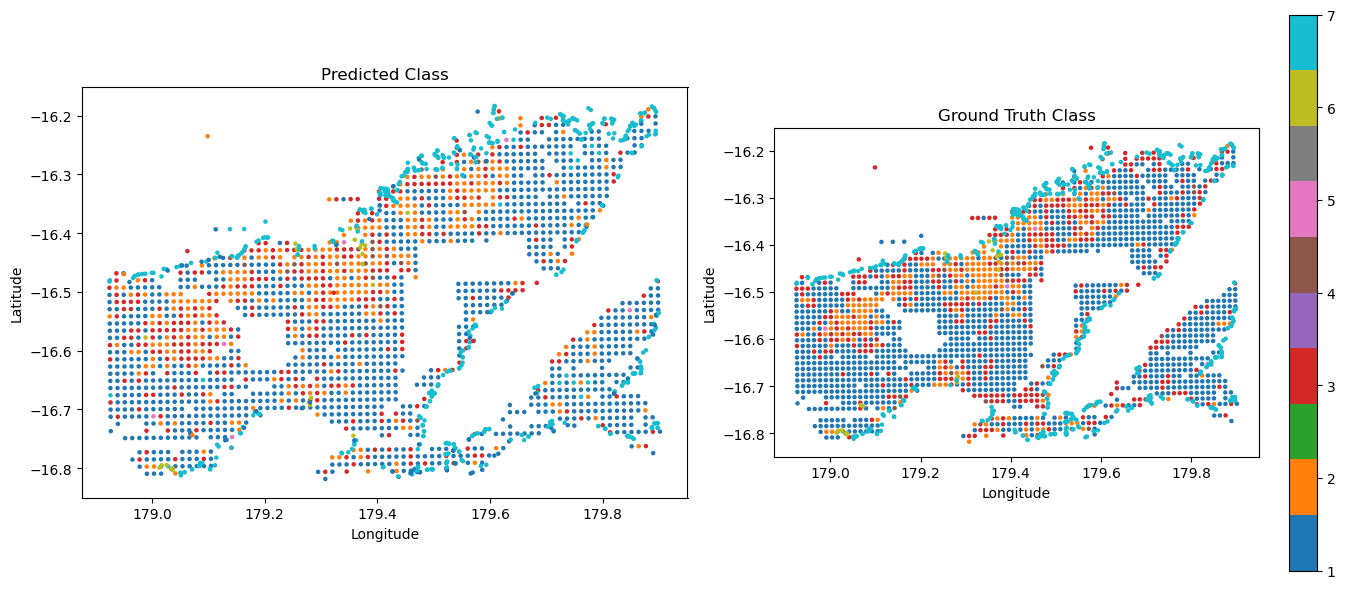

In [250]:
# Plot prediction and groundtruth 
geometry = [Point(xy) for xy in zip(fiji_test['lon'], fiji_test['lat'])]
gdf = gpd.GeoDataFrame(fiji_test, geometry=geometry, crs='EPSG:4326')


fig, axes = plt.subplots(1, 2, figsize=(14, 6))


gdf.plot(column='predicted_class', cmap='tab10', legend=False,
         ax=axes[0], markersize=5)
axes[0].set_title("Predicted Class")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
gdf.plot(column='class_id', cmap='tab10', legend=True,
         ax=axes[1], markersize=5)
axes[1].set_title("Ground Truth Class")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")

plt.tight_layout()
plt.show()

## 4. Comparison with Fractional Cover k-means clustering 

In [120]:
with rasterio.open('bs_pc_50_test.tif') as src:
    bs = src.read(1).astype('float32')
    meta = src.meta

with rasterio.open('pv_pc_50_test.tif') as src:
    pv = src.read(1).astype('float32')

with rasterio.open('npv_pc_50_test.tif') as src:
    npv = src.read(1).astype('float32')

def normalize_band(band, scale=255):
    return np.clip(band / scale, 0, 1)

bs_norm = normalize_band(bs, 255)
pv_norm = normalize_band(pv, 255)
npv_norm = normalize_band(npv, 255)

#  Stack into RGB 
rgb = np.dstack((bs_norm, pv_norm, npv_norm))
rgb = np.clip(rgb, 0, 1)


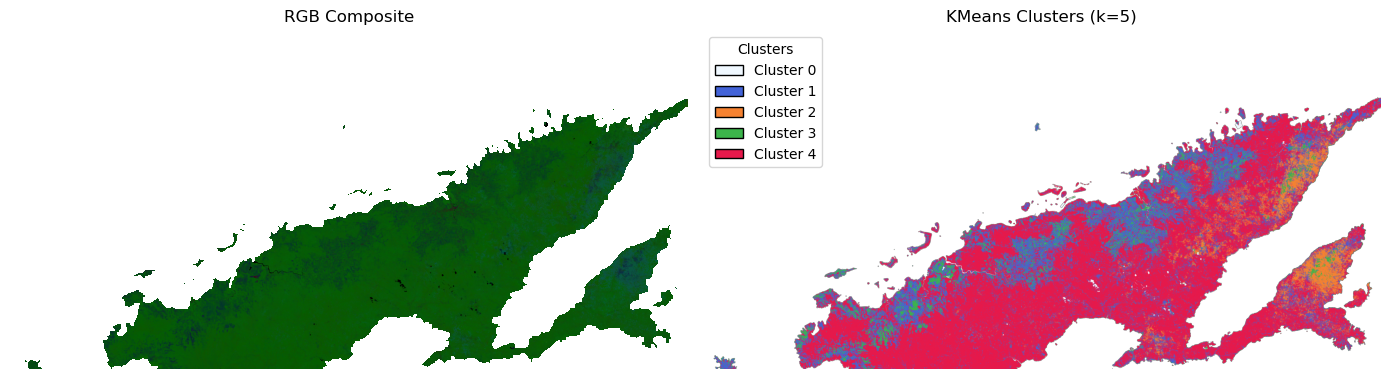

In [121]:
k = 5
h, w, c = rgb.shape

# Prepare Data for Clustering 
flat_rgb = rgb.reshape(-1, 3)
valid_mask = ~np.isnan(flat_rgb).any(axis=1)
rgb_valid = flat_rgb[valid_mask]

# KMeans Clustering
kmeans = KMeans(n_clusters=k, random_state=42)
labels = np.full(flat_rgb.shape[0], np.nan)
labels[valid_mask] = kmeans.fit_predict(rgb_valid)
label_img = labels.reshape(h, w)

# Plot RGB and Cluster Image 
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(rgb)
axes[0].set_title("RGB Composite")
axes[0].axis('off')

fixed_colors = [
    'aliceblue', '#4363d8', '#f58231', '#3cb44b', '#e6194b',
    '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe'
]
cluster_cmap = ListedColormap(fixed_colors[:k])

axes[1].imshow(label_img, cmap=cluster_cmap)
axes[1].set_title(f'KMeans Clusters (k={k})')
axes[1].axis('off')

legend_elements = [
    Patch(facecolor=cluster_cmap(i), edgecolor='black', label=f'Cluster {i}')
    for i in range(k)
]
axes[1].legend(handles=legend_elements, loc='upper left', title='Clusters')
plt.tight_layout()
plt.show()


## Prepare FC Temporal Data

In [2]:
import sys
from pystac_client import Client
import depal_ck as dep
from odc.stac import load
from shapely import geometry
import geopandas as gpd
import rioxarray
from dea_tools.dask import create_local_dask_cluster

client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/philippinel@spc.int/proxy/8787/status,
Dashboard: /user/philippinel@spc.int/proxy/8787/status,Workers: 1
Total threads: 8,Total memory: 57.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36949,Workers: 0
Dashboard: /user/philippinel@spc.int/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:43193,Total threads: 8
Dashboard: /user/philippinel@spc.int/proxy/37347/status,Memory: 57.21 GiB
Nanny: tcp://127.0.0.1:38557,


2025-08-10 23:10:54,331 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 1e008ef82392af37e7b48d60e6e40651 initialized by task ('rechunk-merge-rechunk-transfer-2162401ca4f5a25ec41f6f122053fe55', 0, 1, 1, 2, 1, 1) executed on worker tcp://127.0.0.1:43193
2025-08-10 23:10:54,397 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 1b16b85376b63d97f52ab5ee12bd0e78 initialized by task ('rechunk-merge-rechunk-transfer-2162401ca4f5a25ec41f6f122053fe55', 0, 0, 1, 2, 0, 1) executed on worker tcp://127.0.0.1:43193
2025-08-10 23:11:00,029 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3b21c4301c1cd7c48f500b5ef9ca6113 initialized by task ('rechunk-merge-rechunk-transfer-2162401ca4f5a25ec41f6f122053fe55', 0, 3, 1, 2, 4, 1) executed on worker tcp://127.0.0.1:43193
2025-08-10 23:11:00,183 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle c450de19d415e4632d2114fa49a147d4 initialized by task ('rechunk-merge-rechunk-transfer-2162401ca4f5a25ec41f6f122053fe55', 0, 

In [3]:
catalog = "https://stac.staging.digitalearthpacific.io"
client = Client.open(catalog)
collections = client.get_collections()

In [4]:
fj = dep.get_country_admin_boundary('Fiji', 'Division', "Central")

#fj = dep.get_country_boundary('Palau')
bbox = dep.get_bbox(fj)
bbox_geometry = geometry.box(*bbox)

gdf = gpd.GeoDataFrame({'geometry': [bbox_geometry]}, crs='EPSG:4326')
gdf.explore()


In [ ]:
# List of Palau states
"""
states = [
    "Aimeliik",
    "Airai",
    "Koror",
    "Melekeok",
    "Ngaraard",
    "Ngardmau",
    "Ngatpang",
    "Ngchesar",
    "Ngeremlengui",
    "Ngiwal"
]
"""
# for fiji test state 
states = ['Cakaudrove', 'Macuata']

# Retrieve all boundaries and store in a list
gdfs = [dep.get_country_admin_boundary('Fiji', 'Province', state) for state in states]

# Concatenate into a single GeoDataFrame
fj = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)

# Compute bounding box of the merged geometry
bbox = dep.get_bbox(fj)
bbox = list(bbox)

# uncomment for fiji test
bbox[0] = 178.70143044283932
bbox[2] = 179.95873926040082

bbox_geometry = geometry.box(*bbox)

# Create a GeoDataFrame from the bbox and display
gdf = gpd.GeoDataFrame({'geometry': [bbox_geometry]}, crs='EPSG:4326')
gdf.explore()

### Mask the cloud using other landsat-8 images

To remove cloud-contaminated pixels from the Fractional Cover (FC) dataset, we used the WOFL (Water Observations from Landsat) data, which is derived from the same Landsat-8 imagery. In this dataset, cloud pixels are labeled with the value 1. We applied this cloud mask to exclude those pixels from the FC data, paying attention to match the date between both images.

In [31]:
# WOFL Landsat-8 Image --> USED AS THE MASK
items = client.search(collections=["dep_ls_wofl"], bbox=bbox, datetime="2024-01-01/2024-04-30").item_collection()

items = client.search(
    collections=["dep_ls_wofl"],
    bbox=bbox,
    datetime="2024-01-01/2024-04-30",
).items()
chunks = dict(x=2048, y=2048)

# Load the data
data_temoin = load(items, chunks=chunks)
data_temoin = dep.do_coastal_clip(fj, data_temoin , buffer=0.001)
print(data_temoin)

<xarray.Dataset> Size: 3GB
Dimensions:      (y: 4807, x: 7457, time: 71)
Coordinates:
  * y            (y) float64 38kB -1.739e+06 -1.739e+06 ... -1.883e+06
  * x            (x) float64 60kB 6.88e+05 6.881e+05 ... 9.117e+05 9.117e+05
  * time         (time) datetime64[ns] 568B 2024-01-02T22:12:30.501807 ... 20...
    spatial_ref  int64 8B 0
Data variables:
    water        (time, y, x) uint8 3GB dask.array<chunksize=(1, 855, 317), meta=np.ndarray>


In [32]:
# FC Landsat-8 Image 
items = client.search(
    collections=["dep_ls_fc"],
    bbox=bbox,
    datetime="2024-01-01/2024-04-30",
).items()
chunks = dict(x=2048, y=2048)

# Load the data
data = load(items, chunks=chunks)
data = dep.do_coastal_clip(fj, data, buffer=0.001)
print(data)

<xarray.Dataset> Size: 10GB
Dimensions:      (y: 4807, x: 7457, time: 71)
Coordinates:
  * y            (y) float64 38kB -1.739e+06 -1.739e+06 ... -1.883e+06
  * x            (x) float64 60kB 6.88e+05 6.881e+05 ... 9.117e+05 9.117e+05
  * time         (time) datetime64[ns] 568B 2024-01-02T22:12:30.501807 ... 20...
    spatial_ref  int64 8B 0
Data variables:
    bs           (time, y, x) uint8 3GB dask.array<chunksize=(1, 855, 317), meta=np.ndarray>
    pv           (time, y, x) uint8 3GB dask.array<chunksize=(1, 855, 317), meta=np.ndarray>
    ue           (time, y, x) uint8 3GB dask.array<chunksize=(1, 855, 317), meta=np.ndarray>
    npv          (time, y, x) uint8 3GB dask.array<chunksize=(1, 855, 317), meta=np.ndarray>


In [33]:
# Extract just the dates (YYYY-MM-DD)
data_dates = pd.to_datetime(data.time.values).normalize()
temoin_dates = pd.to_datetime(data_temoin.time.values).normalize()

# Build index mapping by date 
data_idx = {d: i for i, d in enumerate(data_dates)}
temoin_idx = {d: j for j, d in enumerate(temoin_dates)}

# Find common dates
common_dates = sorted(set(data_idx.keys()) & set(temoin_idx.keys()))

# Initialize masked copy
data_masked = data.copy()

# Loop over matching dates
for date in common_dates:
    
    i = data_idx[date]
    j = temoin_idx[date]
    mask = data_temoin['water'].isel(time=j) == 1

    for band in ['bs', 'pv', 'npv']:
        
        band_slice = data[band].isel(time=i)
        mask_aligned = mask.broadcast_like(band_slice)
        masked_slice = band_slice.where(~mask_aligned, 255)
        data_masked[band][i] = masked_slice

In [34]:
print(data_masked)

<xarray.Dataset> Size: 10GB
Dimensions:      (y: 4807, x: 7457, time: 71)
Coordinates:
  * y            (y) float64 38kB -1.739e+06 -1.739e+06 ... -1.883e+06
  * x            (x) float64 60kB 6.88e+05 6.881e+05 ... 9.117e+05 9.117e+05
  * time         (time) datetime64[ns] 568B 2024-01-02T22:12:30.501807 ... 20...
    spatial_ref  int64 8B 0
Data variables:
    bs           (time, y, x) uint8 3GB dask.array<chunksize=(1, 855, 317), meta=np.ndarray>
    pv           (time, y, x) uint8 3GB dask.array<chunksize=(1, 855, 317), meta=np.ndarray>
    ue           (time, y, x) uint8 3GB dask.array<chunksize=(1, 855, 317), meta=np.ndarray>
    npv          (time, y, x) uint8 3GB dask.array<chunksize=(1, 855, 317), meta=np.ndarray>


/srv/conda/envs/notebook/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


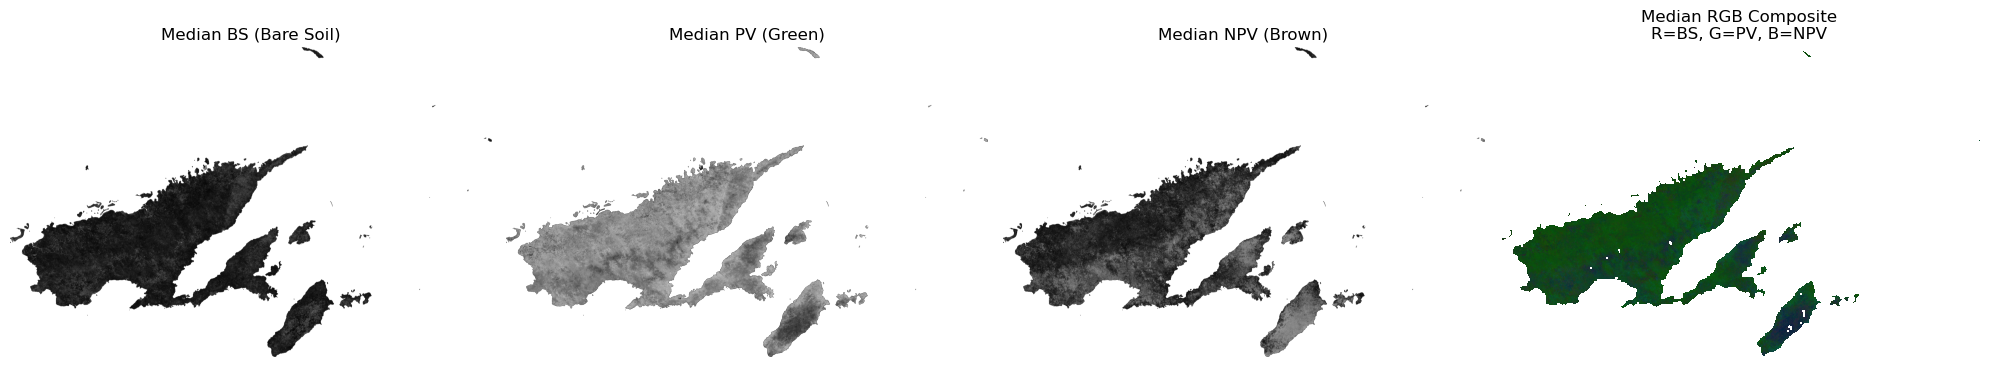

In [19]:
def plot_median_fc_bands_and_rgb(data_masked):
    """
    Compute median over time for bs, pv, npv bands in a masked dataset,
    then plot each band + RGB composite (R=bs, G=pv, B=npv).
    """
    clean = data_masked.where(data_masked != 255)
    median_ds = clean.median(dim="time", skipna=True)

    #  Extract median bands
    bs  = median_ds['bs'].values
    pv  = median_ds['pv'].values
    npv = median_ds['npv'].values

    # Normalize to [0, 1] range
    rgb = np.stack([bs, pv, npv], axis=-1).astype(np.float32)
    rgb = rgb / 255.0

    # Plot
    fig, axs = plt.subplots(1, 4, figsize=(20, 6))

    axs[0].imshow(bs, cmap='gray')
    axs[0].set_title("Median BS (Bare Soil)")
    axs[0].axis('off')

    axs[1].imshow(pv, cmap='gray')
    axs[1].set_title("Median PV (Green)")
    axs[1].axis('off')

    axs[2].imshow(npv, cmap='gray')
    axs[2].set_title("Median NPV (Brown)")
    axs[2].axis('off')

    axs[3].imshow(rgb)
    axs[3].set_title("Median RGB Composite\nR=BS, G=PV, B=NPV")
    axs[3].axis('off')

    plt.tight_layout()
    plt.show()


plot_median_fc_bands_and_rgb(data_masked)

In [35]:
# Compute the median
clean = data_masked.where(data_masked != 255)
median_ds = clean.median(dim="time", skipna=True)

bs_median  = median_ds['bs']
pv_median  = median_ds['pv']
npv_median = median_ds['npv']

# Stack into xarray DataArray 
bands = xr.concat([bs_median, pv_median, npv_median], dim="band")
bands = bands.assign_coords(band=["bs", "pv", "npv"])

# Set CRS and export as GeoTIFF
bands.rio.write_crs("EPSG:32660", inplace=True) 
bands.rio.to_raster("fc_fijitest_jan_apr.tif")
